# **K nearest neighbours**

## Preprocesamiento

In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()



In [ ]:
# Limpieza del dataset

# Eliminamos columnas para train
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)

# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)

df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)


#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )

# Aca la transformacion aplicada viene del dataset de train
df_test['agent'] = df_test['agent'].apply(es_agente_popular )


# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

# Aca la transformacion aplicada viene del dataset de train
df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)

df_test['country'] = df_test['country'].apply(es_pais_atipico)


# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)




#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)


#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')

# No se aplica esto sobre test xq no esta el valor Undefined presente


##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

# Aca la transformacion aplicada viene del dataset de train
df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)


# Elimino las reservas sin personas
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado.reset_index()

,index,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,0,City Hotel,49,2016,September,37,5,1,2,1,...,D,0,No Deposit,9.0,0,Transient,115.50,0,1,1
1,1,Resort Hotel,4,2015,October,44,31,0,1,2,...,A,0,No Deposit,0.0,0,Transient,42.00,1,0,0
2,2,City Hotel,25,2016,October,42,13,0,1,2,...,F,0,No Deposit,9.0,0,Transient,229.00,0,2,0
3,3,City Hotel,26,2016,December,51,12,2,5,2,...,A,0,Non Refund,otro,0,Transient,75.00,0,0,1
4,4,City Hotel,104,2017,March,12,19,2,5,2,...,A,0,No Deposit,otro,0,Transient-Party,75.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61828,61908,Resort Hotel,24,2017,January,4,27,0,2,2,...,D,0,No Deposit,240.0,0,Transient,48.00,0,1,1
61829,61909,City Hotel,0,2016,September,36,2,0,1,1,...,A,0,No Deposit,0.0,0,Transient,149.00,0,0,0
61830,61910,City Hotel,10,2017,May,19,8,1,2,1,...,A,0,No Deposit,0.0,0,Transient,95.00,0,0,0
61831,61911,Resort Hotel,143,2015,October,41,10,2,5,2,...,A,0,Non Refund,otro,0,Transient,36.05,0,0,1


In [ ]:


# Outliers adr
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adluts
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)

#
df_filtrado.drop('zm_adr', axis=1, inplace=True);

1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


In [ ]:
ds_trabajo = pd.get_dummies(df_filtrado, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

df_test = pd.get_dummies(df_test, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)


In [ ]:
# Escalamiento de las variables cuantitativas usando min max scaler


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Para el entrenamiento
ds_trabajo[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']] = scaler.fit_transform(ds_trabajo[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']])
# Para la prediccion
df_test[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']] = scaler.fit_transform(df_test[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']])



## Entrenamiento

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
x = ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y = ds_trabajo['is_canceled'].copy()


#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [ ]:
#Crear el modelo
KNN_Classifier = KNeighborsClassifier()

#vemos sus parámetros
KNN_Classifier.get_params()

#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

accuracy_score(y_test,y_pred)

correctas:  8288
total:  10945


0.7572407492005482

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(1,30) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

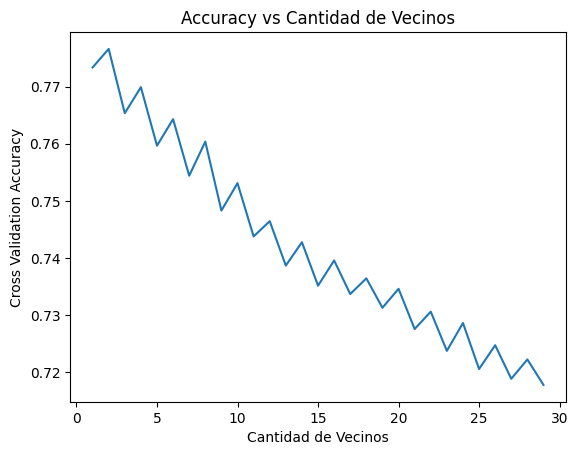

In [ ]:
#ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

## Optimizacion de hiperparametros

Random search and cross validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.77148859, 0.70234598, 0.72045965, 0.62539112, 0.73962406,
       0.75088515, 0.73217753, 0.6875214 , 0.77240232, 0.68528297])

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan', 'algorithm': 'brute'}
0.7724023172190616


              precision    recall  f1-score   support

           0       0.78      0.72      0.75      5475
           1       0.74      0.80      0.77      5470

    accuracy                           0.76     10945
   macro avg       0.76      0.76      0.76     10945
weighted avg       0.76      0.76      0.76     10945



Text(50.722222222222214, 0.5, 'True')

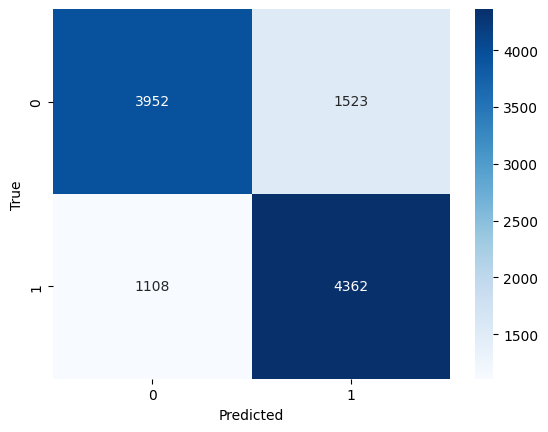

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Prediccion

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#Creo un dataset con los features que voy a usar para clasificar
x = ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)
#Creo un dataset con la variable target
y = ds_trabajo['is_canceled'].copy()


#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
KNN_Classifier= KNeighborsClassifier(weights='distance',n_neighbors= 19, metric= 'manhattan', algorithm='brute')
KNN_Classifier.fit(x_train, y_train)

y_pred = KNN_Classifier.predict(df_test)

In [ ]:

submit =  pd.DataFrame(zip(test_id,y_pred),columns=['id','is_canceled'])
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./knn_submit.csv',index=False)  

##Preparando modelo

In [ ]:
from joblib import dump
dump(KNN_Classifier, 'KNN.joblib') 

from joblib import load
KNN = load('KNN.joblib')
KNN.predict(df_test) 

array([1, 1, 0, ..., 1, 1, 0])

# **SVM**

##Preprocesamiento

In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()

In [ ]:
# Limpieza del dataset

# Eliminamos columnas para train
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)

# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)

df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)


#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )

# Aca la transformacion aplicada viene del dataset de train
df_test['agent'] = df_test['agent'].apply(es_agente_popular )


# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

# Aca la transformacion aplicada viene del dataset de train
df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)

df_test['country'] = df_test['country'].apply(es_pais_atipico)


# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)




#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)


#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')

# No se aplica esto sobre test xq no esta el valor Undefined presente


##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

# Aca la transformacion aplicada viene del dataset de train
df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)


# Elimino las reservas sin personas
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado.reset_index()

,index,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,0,City Hotel,49,2016,September,37,5,1,2,1,...,D,0,No Deposit,9.0,0,Transient,115.50,0,1,1
1,1,Resort Hotel,4,2015,October,44,31,0,1,2,...,A,0,No Deposit,0.0,0,Transient,42.00,1,0,0
2,2,City Hotel,25,2016,October,42,13,0,1,2,...,F,0,No Deposit,9.0,0,Transient,229.00,0,2,0
3,3,City Hotel,26,2016,December,51,12,2,5,2,...,A,0,Non Refund,otro,0,Transient,75.00,0,0,1
4,4,City Hotel,104,2017,March,12,19,2,5,2,...,A,0,No Deposit,otro,0,Transient-Party,75.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61828,61908,Resort Hotel,24,2017,January,4,27,0,2,2,...,D,0,No Deposit,240.0,0,Transient,48.00,0,1,1
61829,61909,City Hotel,0,2016,September,36,2,0,1,1,...,A,0,No Deposit,0.0,0,Transient,149.00,0,0,0
61830,61910,City Hotel,10,2017,May,19,8,1,2,1,...,A,0,No Deposit,0.0,0,Transient,95.00,0,0,0
61831,61911,Resort Hotel,143,2015,October,41,10,2,5,2,...,A,0,Non Refund,otro,0,Transient,36.05,0,0,1


In [ ]:
# Outliers adr
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adluts
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)

#
df_filtrado.drop('zm_adr', axis=1, inplace=True);

1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


In [ ]:
#quito las columnas con valor categorico
columnas_a_despreciar = ['hotel','arrival_date_month','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','agent','customer_type','is_repeated_guest']
df_svm = df_filtrado.drop(columnas_a_despreciar,axis='columns',inplace=False)
df_svm.dtypes

lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
is_canceled                         int64
dtype: object

##Entrenamiento

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:
x = df_svm.drop(['is_canceled'],axis='columns',inplace=False)
y = df_svm['is_canceled'].copy()
#Creo conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Text(0, 0.5, 'Varianza Explicada (%)')

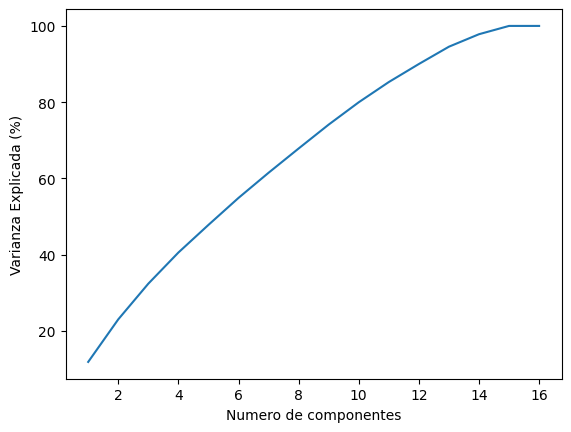

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Escalo los datos de entrenamiento
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)

# PCA sobre los datos escalados
pca = PCA(n_components = None)
x_train_pca = pca.fit_transform(x_train_scaled)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

In [ ]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(x_train_pca,y_train)


SVC()

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      8233
           1       0.78      0.70      0.74      8185

    accuracy                           0.75     16418
   macro avg       0.75      0.75      0.75     16418
weighted avg       0.75      0.75      0.75     16418



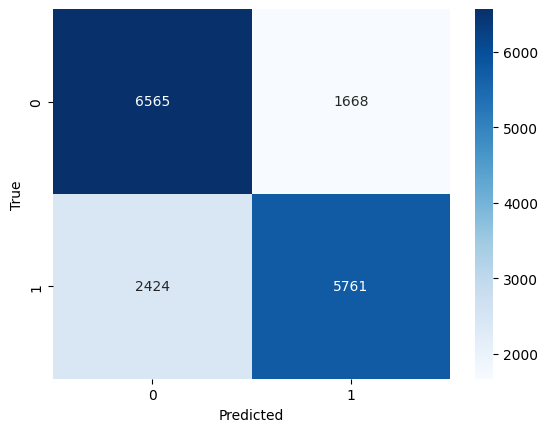

In [ ]:
x_test_norm = sc.transform(x_test)
x_test_pca = pca.transform(x_test_norm)
y_pred_pca=svm.predict(x_test_pca)
metricas(y_pred_pca,y_test)

##Optimizacion de hiperparametros

In [ ]:
import sklearn as sk
from sklearn.model_selection import StratifiedKFold, KFold,GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

#Conjunto de parámetros que quiero usar
params_grid = {'kernel':['rbf'],
               'C':[42,43],
               }
                
#Cantidad de splits para el Cross Validation
folds=2

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_svm = SVC() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
gridcv = GridSearchCV(estimator=base_svm,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
gridcv.fit(x_train_pca,y_train);

In [ ]:
gridcv.best_params_

{'C': 42, 'kernel': 'rbf'}

In [ ]:
gridcv.best_score_

0.7430902161989053

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      8233
           1       0.77      0.72      0.75      8185

    accuracy                           0.76     16418
   macro avg       0.76      0.76      0.76     16418
weighted avg       0.76      0.76      0.76     16418



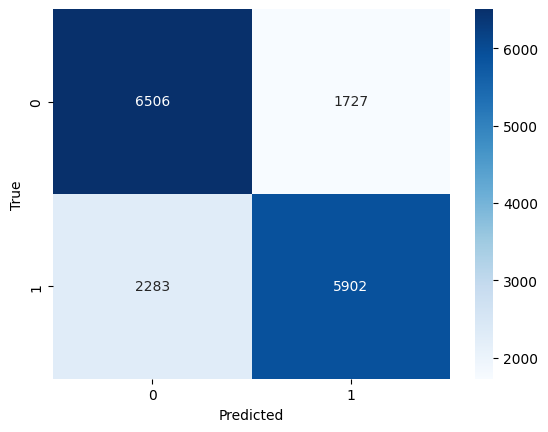

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
##Tomare 12 componentes
_pca = PCA(n_components = 12)
_model = SVC(kernel='rbf', C=42)

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test)
metricas(y_pred_pca,y_test)


##Prediccion

In [ ]:
df_test_svm = df_test.copy()
df_test_svm.columns.to_list()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [ ]:
df_test_svm = df_test.copy()
df_test_svm.drop(columnas_a_despreciar, axis=1, inplace=True);

df_test_svm = sc.transform(df_test_svm)
df_test_svm = pca.transform(df_test_svm)

y_pred = svm_model.predict(df_test_svm)

In [ ]:
svm_submit =  pd.DataFrame(zip(test_id,y_pred),columns=['id','is_canceled'])
svm_submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,1
26531,11e19741-bd28-4459-8ea3-184f1664000f,1
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./svm_submit.csv',index=False)  

##Preparando modelo

In [ ]:
from joblib import dump
dump(svm_model, 'SVM.joblib') 

from joblib import load
SVM = load('SVM.joblib')
SVM.predict(df_test_svm) 

array([0, 0, 0, ..., 0, 0, 0])

# **XGBoost**

## Preprocesamiento

In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()

# Limpieza del dataset

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)


# Eliminamos columnas
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)

df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)




#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )
df_test['agent'] = df_test['agent'].apply(es_agente_popular )

# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)


df_test['country'] = df_test['country'].apply(es_pais_atipico)


# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)


#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)



#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')





##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)




##categorizo las columnas menos populares con el nombre de "otro"
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado.reset_index()

# Outliers adr
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adluts
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)


df_filtrado.drop('zm_adr', axis=1, inplace=True);




1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


In [ ]:
ds_trabajo = pd.get_dummies(df_filtrado, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

In [ ]:
# Esto es para el escalado
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#ds_trabajo[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']] = scaler.fit_transform(ds_trabajo[['adr', 'babies', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'booking_changes', 'children']])

## Entrenamiento

In [ ]:
#Creo el modelo y lo entreno
import xgboost as xgb
#Creo un dataset con los features que voy a usar para clasificar
x = ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y = ds_trabajo['is_canceled'].copy()


#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

AUC: 0.9542064394413697
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5475
           1       0.87      0.89      0.88      5470

    accuracy                           0.88     10945
   macro avg       0.88      0.88      0.88     10945
weighted avg       0.88      0.88      0.88     10945



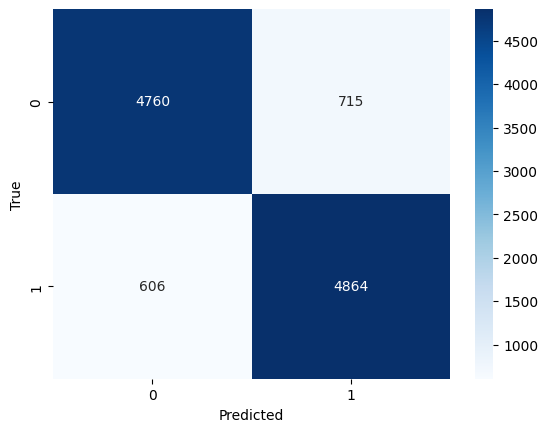

In [ ]:
#Evaluo en el set de test
from sklearn.metrics import roc_auc_score
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))


## Optimizacion de hiperparametros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'learning_rate':np.linspace(0.1,0.5,5), 
              'n_estimators':range(10,100),
              'max_depth':range(4,10),
             'objective':['reg:logistic','binary:logistic']
             }

             


#Clasificador xgb
xgb_model = xgb.XGBClassifier(random_state=0)

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(xgb_model, params_grid, cv=5, scoring='accuracy', n_iter=5, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.86735655, 0.85758028, 0.8741635 , 0.86936668, 0.875534  ])

In [ ]:
rand.best_params_

{'objective': 'reg:logistic',
 'n_estimators': 93,
 'max_depth': 8,
 'learning_rate': 0.30000000000000004}

Mejores hiperparametros:
{'objective': 'reg:logistic',
 'n_estimators': 93,
 'max_depth': 8,
 'learning_rate': 0.30000000000000004}

In [ ]:
import xgboost as xgb


y = ds_trabajo['is_canceled'].copy()
x = ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

xgb_model = xgb.XGBClassifier(random_state=0, objective='reg:logistic', n_estimators=93,max_depth=8,learning_rate=0.3)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=93, n_jobs=None, num_parallel_tree=None,
              objective='reg:logistic', predictor=None, ...)

In [ ]:
predict_y_test = xgb_model.predict(x_test)

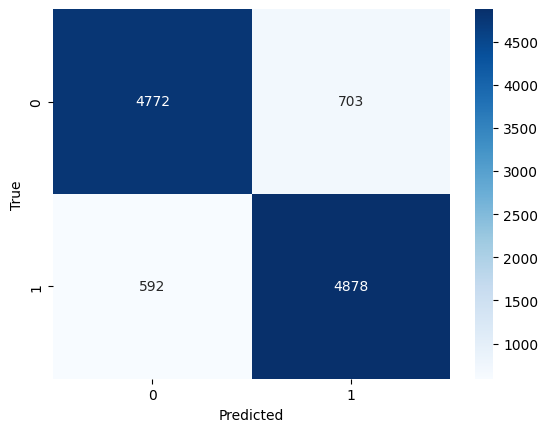

In [ ]:
tabla = confusion_matrix(y_test, predict_y_test)

sns.heatmap(tabla, cmap = 'Blues',annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

##Prediccion

In [ ]:
y_pred = xgb_model.predict(df_test)

In [ ]:
submit =  pd.DataFrame(zip(test_id,y_pred),columns=['id','is_canceled'])
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./xgboost_submit.csv',index=False)  

##Preparando modelo

In [ ]:
from joblib import dump
dump(xgb_model, 'xgboost.joblib') 

from joblib import load
xgboost = load('xgboost.joblib')
xgboost.predict(df_test) 

array([1, 1, 0, ..., 1, 1, 0])

#**Random Forest**

##Preprocesamiento

In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

In [ ]:
# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()

Limpieza del Dataset:

In [ ]:
# Limpieza del dataset

# Eliminamos columnas
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)

Nulos:

In [ ]:
# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)


df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)

#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)

Agrupacion de registros para algunas variables:

In [ ]:
#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )


# Aca la transformacion aplicada viene del dataset de train
df_test['agent'] = df_test['agent'].apply(es_agente_popular )

# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)

df_test['country'] = df_test['country'].apply(es_pais_atipico)

# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)

#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')


##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

# Aca la transformacion aplicada viene del dataset de train
df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)


##categorizo las columnas menos populares con el nombre de "otro"
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado = df_filtrado.reset_index()

Outliers:

In [ ]:
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adults
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)

df_filtrado.drop('zm_adr', axis=1, inplace=True);

1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


In [ ]:
ds_trabajo = pd.get_dummies(df_filtrado, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

##Entrenamiento

###Separación para entrenamiento y para test

In [ ]:
#Librerias necesarias para el entrenamiento del modelo
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#Dataset creado para la etapa de predicción
ds_trabajo_predic = ds_trabajo.copy()

In [ ]:
target = ds_trabajo['is_canceled']
ds_trabajo.drop(['is_canceled'],axis=1,inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo, target, test_size = 0.3, random_state = 3)

print("Cantidad de datos Training: " + str(len(x_train)))
print("Cantidad de datos Testing: " + str(len(x_test)))

Cantidad de datos Training: 38326
Cantidad de datos Testing: 16426


###Random Forest con parámetros por defecto

In [ ]:
rfc_default = RandomForestClassifier()
rfc_default.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
predict_y_test_default = rfc_default.predict(x_test)

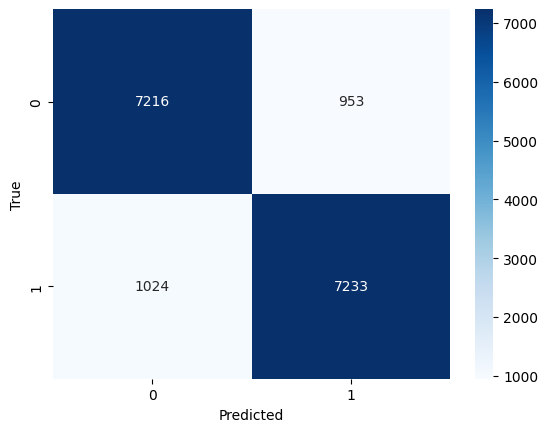

In [ ]:
tabla = confusion_matrix(y_test, predict_y_test_default)

sns.heatmap(tabla, cmap = 'Blues',annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test, predict_y_test_default))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      8169
           1       0.88      0.88      0.88      8257

    accuracy                           0.88     16426
   macro avg       0.88      0.88      0.88     16426
weighted avg       0.88      0.88      0.88     16426



##Optimización de hiperparametros

###Grid Search

Empezamos la búsqueda de hiperparámetros con Grid Search:

In [ ]:
n = 10
folds = 5

kfoldcv = StratifiedKFold(n_splits=folds)

score = make_scorer(sk.metrics.f1_score)

random_forest = RandomForestClassifier(max_features='auto', oob_score=True, random_state=3, n_jobs=-1)

params_grid = {'criterion' : ['gini', 'entropy'], 
               'min_samples_leaf':[1,2],
               'min_samples_split': [2,3],
               'n_estimators':[30,40]
              }

rs_cv = GridSearchCV(estimator = random_forest, param_grid = params_grid, scoring = score, cv = kfoldcv, n_jobs=-1)
ds_fit = rs_cv.fit(X= x_train, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
ds_fit.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 40}

In [ ]:
ds_fit.best_score_

0.880258950756738

In [ ]:
ds_fit.cv_results_['mean_test_score']

array([0.8758484 , 0.87633138, 0.87875321, 0.88025895, 0.87429707,
       0.87451935, 0.87429707, 0.87451935, 0.87703289, 0.87882414,
       0.87819087, 0.87899014, 0.8751176 , 0.87611333, 0.8751176 ,
       0.87611333])

In [ ]:
best_rf_fit = ds_fit.best_estimator_

In [ ]:
predict_y_test = best_rf_fit.predict(x_test)

In [ ]:
predict_y_test

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
y_test.values

array([0, 1, 1, ..., 1, 0, 0])

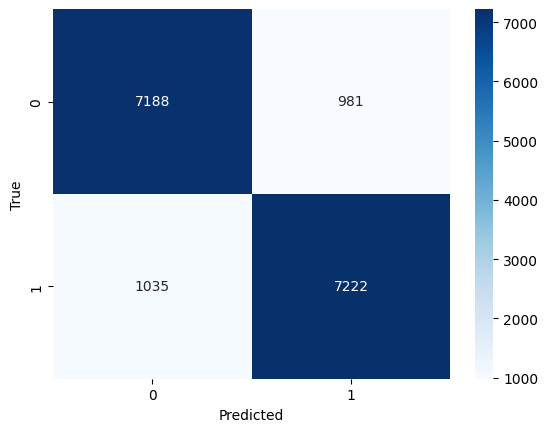

In [ ]:
tabla = confusion_matrix(y_test, predict_y_test)

sns.heatmap(tabla, cmap = 'Blues',annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test, predict_y_test))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      8169
           1       0.88      0.87      0.88      8257

    accuracy                           0.88     16426
   macro avg       0.88      0.88      0.88     16426
weighted avg       0.88      0.88      0.88     16426



Podemos ver que los resultados de las métricas con Grid Search no son muy diferentes a las de un Random Forest con parametros por defecto. Además es mucho más costoso de realizar

###Random Search

In [ ]:
#Pruebo Random Search Cross Validation 
#Cantidad de combinaciones que quiero porbar
n=15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':[1],
               'min_samples_split': list(range(1,7)),
               'n_estimators':list(range(60,100))
               }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=rf_cv,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [ ]:
randomcv.best_params_

{'n_estimators': 87,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'criterion': 'entropy'}

In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.88304138, 0.88035534,        nan, 0.88243971, 0.8818463 ,
       0.88221313, 0.88127739, 0.88262857, 0.88036913, 0.87918565,
       0.88013876, 0.88203884, 0.88229075, 0.87914165,        nan])

In [ ]:
randomcv.best_score_

0.8830413802731678

In [ ]:
best_fit = randomcv.best_estimator_

In [ ]:
predict_y_test = best_fit.predict(x_test)

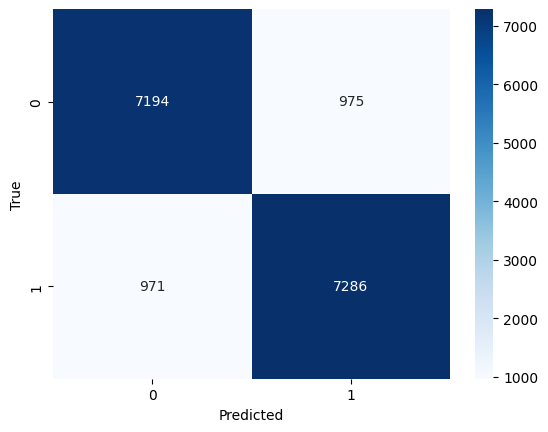

In [ ]:
tabla = confusion_matrix(y_test, predict_y_test)

sns.heatmap(tabla, cmap = 'Blues',annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test, predict_y_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      8169
           1       0.88      0.88      0.88      8257

    accuracy                           0.88     16426
   macro avg       0.88      0.88      0.88     16426
weighted avg       0.88      0.88      0.88     16426



## Prediccion

In [ ]:
ds_trabajo_predic.drop('index', axis=1, inplace=True)

In [ ]:
best_random_forest = RandomForestClassifier(max_features='auto', oob_score=True, random_state=3, n_jobs=-1, n_estimators=94, min_samples_split=2,min_samples_leaf=1,criterion='entropy')

y = ds_trabajo_predic['is_canceled'].copy()
x = ds_trabajo_predic.drop(['is_canceled'], axis='columns', inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

best_random_forest.fit(x_train, y_train)
y_pred = best_random_forest.predict(df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
submit =  pd.DataFrame(zip(test_id,y_pred),columns=['id','is_canceled'])
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./random_forest_submit.csv',index=False)  

##Preparando modelo

In [ ]:
from joblib import dump
dump(best_random_forest, 'random_forest.joblib') 

from joblib import load
random_forest = load('random_forest.joblib')
random_forest.predict(df_test) 

array([1, 1, 0, ..., 1, 1, 0])

#**Ensamble Hibrido**


##Preprocesamiento


In [ ]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Outliers
import scipy.stats as st

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Cargo el data set
direc = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_train.csv"
direc_test = "https://raw.githubusercontent.com/Akselas/7506R-1C2023-GRUPO26/main/hotels_test.csv"
df_test = pd.read_csv(direc_test)
df = pd.read_csv(direc)
df_filtrado  = df.copy()

# Limpieza del dataset

# Eliminamos columnas para train
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop("reservation_status", axis=1)
df_filtrado = df_filtrado.drop("reservation_status_date", axis=1)
df_filtrado = df_filtrado.drop("company", axis=1)

# Eliminamos columnas para test
test_id = df_test.id.copy()
df_test = df_test.drop('id', axis=1)
df_test = df_test.drop("reservation_status", axis=1)
df_test = df_test.drop("reservation_status_date", axis=1)
df_test = df_test.drop("company", axis=1)

# Se reemplazan los valores nulos por 0 en agents
df_filtrado['agent'] = df_filtrado['agent'].fillna(0)
df_filtrado['agent'] = df_filtrado['agent'].astype(str)

df_test['agent'] = df_test['agent'].fillna(0)
df_test['agent'] = df_test['agent'].astype(str)


#Categorizo los agentes menos populares(no incluyo los agentes 0)
agentes_populares = df_filtrado['agent'].value_counts().index.to_list()[0:14]
def es_agente_popular(agent):
  if agent in agentes_populares:
    return agent
  elif agent == 0:
    return agent
  else:
    return 'otro'

df_filtrado['agent'] = df_filtrado['agent'].apply(es_agente_popular )

# Aca la transformacion aplicada viene del dataset de train
df_test['agent'] = df_test['agent'].apply(es_agente_popular )


# Reemplazamos todas las aparaiciones de paises con pocas apariciones en un pais "otro"
paises = df_filtrado['country'].value_counts()
paises_atipicos = paises[ paises <=100].index.to_list()
def es_pais_atipico(pais):
  if pais in paises_atipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais

# Aca la transformacion aplicada viene del dataset de train
df_filtrado['country'] = df_filtrado['country'].apply( es_pais_atipico)

df_test['country'] = df_test['country'].apply(es_pais_atipico)


# Esta funcion es solo para test, a todos los paises que no estan en train los categoriza como otro
paises_tipicos = paises[ paises > 100].index.to_list()
def pertenece_a_pais_de_train(pais):
  if pais in paises_atipicos or pais not in paises_tipicos or pd.isna(pais) :
    return 'otro'
  else:
    return pais
df_test['country'] = df_test['country'].apply(pertenece_a_pais_de_train)




#caso de datos nulos en children
#le agrego el valor que mas predomina, que es 0
df_filtrado['children'] = df_filtrado['children'].apply(lambda child: 0 if pd.isna(child) else child)
df_test['children'] = df_test['children'].apply(lambda child: 0 if pd.isna(child) else child)


#caso market segment y distribution channel
a = df_filtrado[df_filtrado['market_segment'] == 'Undefined'].index
df_filtrado.drop(a,  inplace=True, errors='ignore')

b = df_filtrado[df_filtrado['distribution_channel'] == 'Undefined'].index
df_filtrado.drop(b,  inplace=True, errors='ignore')

# No se aplica esto sobre test xq no esta el valor Undefined presente


##categorizo las columnas menos populares con el nombre de "otro"
rooms_mas_populares = df_filtrado['assigned_room_type'].value_counts().index.to_list()[0:8]
df_filtrado['assigned_room_type'] =df_filtrado['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_filtrado['reserved_room_type'] =df_filtrado['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)

# Aca la transformacion aplicada viene del dataset de train
df_test['assigned_room_type'] =df_test['assigned_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)
df_test['reserved_room_type'] =df_test['reserved_room_type'].apply( lambda room: 'otro' if room not in rooms_mas_populares else room)


# Elimino las reservas sin personas
indices_filas_cero = df_filtrado.loc[(df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)].index
df_filtrado = df_filtrado.drop(indices_filas_cero ,errors ='ignore', axis=0)
df_filtrado.reset_index()

# Outliers adr
#Observamos valores negativos que son anomalos
outlier_adr = df_filtrado[df_filtrado["adr"]<=0]


#ELIMINACION de outlier por indice de fila
indice_outlier=df_filtrado[df_filtrado['adr']<=0].index

df_filtrado.drop(indice_outlier, inplace=True)

#Hago z-score modificado
mediana_adr=np.median(df_filtrado.adr)
MAD=np.median(np.absolute(df_filtrado.adr-mediana_adr))
df_filtrado['zm_adr']=(df_filtrado.adr - mediana_adr )*0.6745/MAD
#usando la regla de oro dropeo los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_filtrado[df_filtrado['zm_adr']>3.5].index
print(len(indice_outlier_z))
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para adluts
df_copia_adults = df_filtrado.copy()

#Hago z-score modificado
mediana_adults = np.median(df.adults)
MAD = np.median(np.absolute(df_copia_adults.adults - mediana_adults))
df_copia_adults['zm_adults'] = (df_copia_adults.adults - mediana_adults ) * 0.6745/MAD
indice_outlier_z = df_copia_adults[df_copia_adults['zm_adults'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")
df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outliers para babys
df_copia_babies = df_filtrado.copy()
#Hago z-score modificado
mediana_babies = np.median(df.babies)
MAD = np.median(np.absolute(df_copia_babies.babies - mediana_babies))
df_copia_babies['zm_babies'] = (df_copia_babies.babies - mediana_babies ) * 0.6745/MAD
indice_outlier_z = df_copia_babies[df_copia_babies['zm_babies'] > 3.5].index
print(f"Cantidad de outliers encontrados con z-score: {len(indice_outlier_z)}")

df_filtrado.drop(indice_outlier_z, inplace=True,axis=0)


# Outilers para days_in_waiting_list
#Hago z-score
df_diwl = df_filtrado.copy()
df_diwl['z_diwl'] = st.zscore(df_diwl['days_in_waiting_list'])
indices = df_diwl[df_diwl['z_diwl'] > 3].index
df_fitrado = df_filtrado.drop(indices, axis=0, inplace=True,errors="ignore")


#busco outliers para lead_time
df_lead = df_filtrado.copy()

#Hago z-score modificado
mediana_lead = np.median(df.lead_time)
MAD = np.median(np.absolute(df.lead_time - mediana_lead))
df_lead['zm_lead_time']=(df.lead_time - mediana_lead )*0.6745/MAD
#ELIMINACION: usando la regla de oro ELIMINO los que tengan un z-score modificado mayor a 3.5
indice_outlier_z = df_lead[df_lead['zm_lead_time']>3.5].index
#son 1079 outliers
df_filtrado.drop(indice_outlier_z, inplace=True, errors='ignore',axis=0)

#
df_filtrado.drop('zm_adr', axis=1, inplace=True);

1023
Cantidad de outliers encontrados con z-score: 2968
Cantidad de outliers encontrados con z-score: 392


##Entrenamiento

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [ ]:
ds_trabajo = pd.get_dummies(df_filtrado, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

df_test = pd.get_dummies(df_test, columns=["hotel","arrival_date_month","deposit_type","reserved_room_type","assigned_room_type","customer_type","meal","market_segment","distribution_channel","agent","country"], drop_first=True)

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
x = ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y = ds_trabajo['is_canceled'].copy()


#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [ ]:
### CASO VOTING
#Creo clasificadores

xgb_clf = xgb.XGBClassifier(objective='reg:logistic',max_depth=8,learning_rate=0.3, n_estimators= 93)
rnd_clf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=3, n_jobs=-1, n_estimators=34, min_samples_split=7,min_samples_leaf=1,criterion='entropy')
knn_clf = KNeighborsClassifier(weights='distance',n_neighbors= 19, metric= 'manhattan', algorithm='brute')



#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('xgb', xgb_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

0.8775696665143902

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5537
           1       0.87      0.88      0.88      5408

    accuracy                           0.88     10945
   macro avg       0.88      0.88      0.88     10945
weighted avg       0.88      0.88      0.88     10945



Text(50.722222222222214, 0.5, 'True')

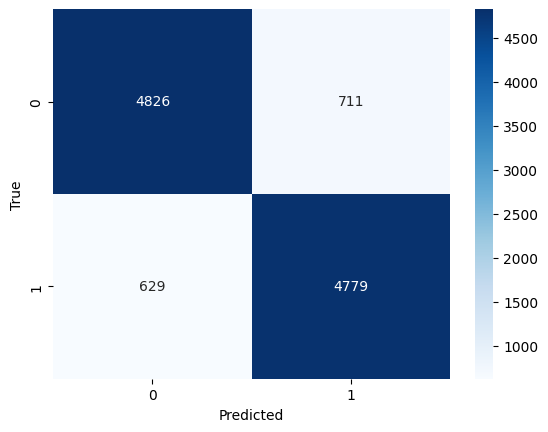

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
##CASO STACKING
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(max_features='auto', oob_score=True, random_state=3, n_jobs=-1, n_estimators=34, min_samples_split=7,min_samples_leaf=1,criterion='entropy')),
               #('svm', SVC()),
               ('knn', KNeighborsClassifier(weights='distance',n_neighbors= 19, metric= 'manhattan', algorithm='brute'))]

#Meta Modelo
meta_model = xgb.XGBClassifier(objective='reg:logistic',max_depth=8,learning_rate=0.3, n_estimators= 93)

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


0.877843764275925

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5537
           1       0.87      0.88      0.88      5408

    accuracy                           0.88     10945
   macro avg       0.88      0.88      0.88     10945
weighted avg       0.88      0.88      0.88     10945



Text(50.722222222222214, 0.5, 'True')

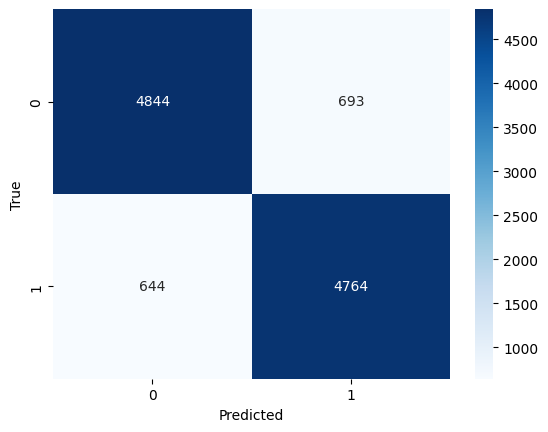

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred_st))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_st)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

##Prediccion

In [ ]:
### CASO VOTING
y_predic =  vot_clf.predict(df_test)

In [ ]:
submit =  pd.DataFrame(zip(test_id,y_predic),columns=['id','is_canceled'])
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./voting_submit.csv',index=False)  

In [ ]:
###CASO STACKING
y_predic =  stacking_model.predict(df_test)

In [ ]:
submit =  pd.DataFrame(zip(test_id,y_predic),columns=['id','is_canceled'])
submit

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
submit.to_csv('./stacking_submit.csv',index=False)  

##Preparando modelo


In [ ]:
###CASO VOTING
from joblib import dump
dump(vot_clf, 'voting.joblib') 

from joblib import load
voting = load('voting.joblib')
voting.predict(df_test) 

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
###CASO STACKING
from joblib import dump
dump(stacking_model, 'stacking.joblib') 

from joblib import load
stacking = load('stacking.joblib')
stacking.predict(df_test) 

array([1, 1, 0, ..., 1, 1, 0])